In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.3.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_hPa_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_hPa_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Birth_Time, Begin_Time, Compl_Time, Death_Time, Peak_Time, Months = [], [], [], [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
        Months.append(Month(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipate Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    Data_DF["Month"] = Months
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Dissipate Time"] = Death_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
VLT_Bins = Create_Bins(-600,600,50)
B_Bins = Create_Bins(-45,135,7.5)
Bins_Bounds = numpy.array([-600,600,50,-45,135,7.5])

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [10]:
# Create Function to Calculate Phase Space Distribution
def Phase_Space_Distr(DF, VLT_Bins, B_Bins, Model, Rela):
    Length = len(DF)
    VLT_B_Count, VLT_VUT_Count = Phase_Space_Count(DF, Length, VLT_Bins, B_Bins, 0, 0, 0)
#
# Calculate Phase Space Density
    if Rela == True:
        VLT_B_Density = VLT_B_Count / Length * 1000
        VLT_VUT_Density = VLT_VUT_Count / Length * 1000
        return (VLT_B_Density, VLT_VUT_Density)
#
# Calculate Phase Space Annual
    else:
        if Model == "Control":
            Num_Year = 90
        else:
            Num_Year = 93
        VLT_B_Annual = VLT_B_Count / Num_Year
        VLT_VUT_Annual = VLT_VUT_Count / Num_Year
        return (VLT_B_Annual, VLT_VUT_Annual)

In [11]:
# Count Phase Space Distribution
def Phase_Space_Count(DF, Length, VLT_Bins, B_Bins, Param_VLT, Param_B, Param_VUT):
    VLT_B_Count = numpy.zeros((len(B_Bins)-1, len(VLT_Bins)-1))
    VLT_VUT_Count = numpy.zeros((len(VLT_Bins)-1, len(VLT_Bins)-1))
    VLT_B_Length = 0
    VLT_VUT_Length = 0
    for i in range(len(DF["VLT"])):
        for j in range(len(VLT_Bins)-1):
            if DF["VLT"][i] >= VLT_Bins[j]-Param_VLT and DF["VLT"][i] <= VLT_Bins[j+1]+Param_VLT:
                for k in range(len(B_Bins)-1):
                    if DF["B"][i] >= B_Bins[k]-Param_B and DF["B"][i] <= B_Bins[k+1]+Param_B:
                        VLT_B_Count[k][j] += 1
                        VLT_B_Length += 1
                for l in range(len(VLT_Bins)-1):
                    if DF["VUT"][i] >= VLT_Bins[l]-Param_VUT and DF["VUT"][i] <= VLT_Bins[l+1]+Param_VUT:
                        VLT_VUT_Count[l][j] += 1
                        VLT_VUT_Length += 1
    VLT_B_Final = VLT_B_Count / VLT_B_Length * Length
    VLT_VUT_Final = VLT_VUT_Count / VLT_VUT_Length * Length
    return (VLT_B_Final, VLT_VUT_Final)

In [12]:
# Calculate Percentage of Points in Each Quadrant
def Phase_Space_Quadrant(Density, Var, Rela):
    if Rela == True:
        Density = Density / 1000
    y_Length = len(Density)
    x_Length = len(Density[0])
    x_Mid = int(x_Length / 2)
    if Var == "VUT":
        y_Mid = int(y_Length / 2)
    elif Var == "B":
        y_Mid = int(y_Length / 3)
    Bottom_Half = Density[:y_Mid]
    Top_Half = Density[y_Mid:]
    Q1 = 0
    Q2 = 0
    Q3 = 0
    Q4 = 0
    for i in range(len(Bottom_Half)):
        Bottom_Right = numpy.sum(Bottom_Half[i][x_Mid:])
        Q4 += Bottom_Right
        Bottom_Left = numpy.sum(Bottom_Half[i][:x_Mid])
        Q3 += Bottom_Left
    for j in range(len(Top_Half)):
        Top_Right = numpy.sum(Top_Half[j][x_Mid:])
        Q1 += Top_Right
        Top_Left = numpy.sum(Top_Half[j][:x_Mid])
        Q2 += Top_Left
    return (numpy.array([Q1, Q2, Q3, Q4]))

In [13]:
# Create Function For Colours
Distr_Colours = ['lightskyblue', 'deepskyblue', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'orange', 'red']
Rela_Distr_Bounds = numpy.array([0.0001,1,2,5,10,20,30,40])
Annual_Distr_Bounds = numpy.array([0.0001,0.1,0.2,0.5,1,2,3,4])

In [14]:
# Plot Cyclone Phase Distribution
def Phase_Distr_Plot(DF, Model, Rela, Smooth, Savefig, Figname):
# Use Function to Calculate Distributions
    if Smooth == False:
        VLT_B, VLT_VUT = Phase_Space_Distr(DF, VLT_Bins, B_Bins, Model, Rela)
#
# Define Colours and Bounds
    if Rela == True:
        Bounds = Rela_Distr_Bounds
        Colours = Distr_Colours
    else:
        Bounds = Annual_Distr_Bounds
        Colours = Distr_Colours
    Fig = pyplot.figure(figsize=(16,8))
#
# VLT B Distribution
    Axis = Fig.add_subplot(1,2,1)
    VLT_Vals = VLT_Bins[1:] - 25
    B_Vals = B_Bins[1:] - 4.75
    pyplot.contourf(VLT_Vals, B_Vals, VLT_B, levels=Bounds, colors=Colours, extend='max')
    Phase_Distr_Formatting("B", Model, Rela, Axis)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_B, "B", Rela)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(1,2,2)
    VLT_Vals = VLT_Bins[1:] - 25
    VUT_Vals = VLT_Bins[1:] - 25
    pyplot.contourf(VLT_Vals, VUT_Vals, VLT_VUT, levels=Bounds, colors=Colours, extend='max')
    Phase_Distr_Formatting("VUT", Model, Rela, Axis)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT, "VUT", Rela)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    if Rela == True:
        Cbar_Label = 'Density (Per 1000 Data Points)'
    else:
        Cbar_Label = 'Density (Per Year)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=Cbar_Label, ticks=Bounds, shrink=0.7)
#
# Save Fig
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname+'.png', bbox_inches='tight')

In [15]:
# Formatting For Cyclone Phase Distribution Plot
def Phase_Distr_Formatting(y_Var, Model, Rela, Axis):
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    if y_Var == "B":
        y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
        pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
        pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    else:
        y_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
        pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
        pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel(y_Var, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Rela == True:
        pyplot.title(str(Model + ' (Relative)'), fontsize=18)
    else:
        pyplot.title(str(Model + ' (Annual)'), fontsize=18)

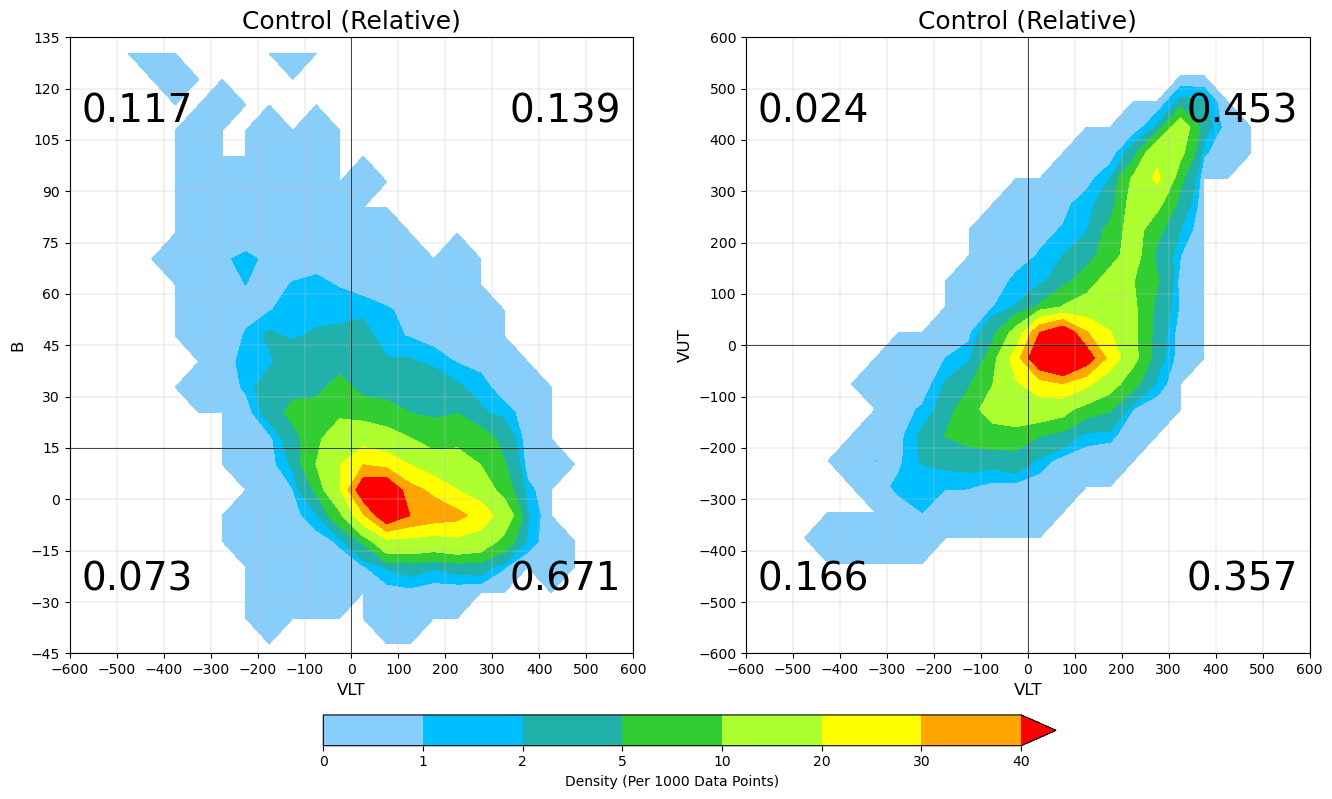

In [16]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_Data, "Control", True, False, True, "Control_Phase_Distr_Rela")

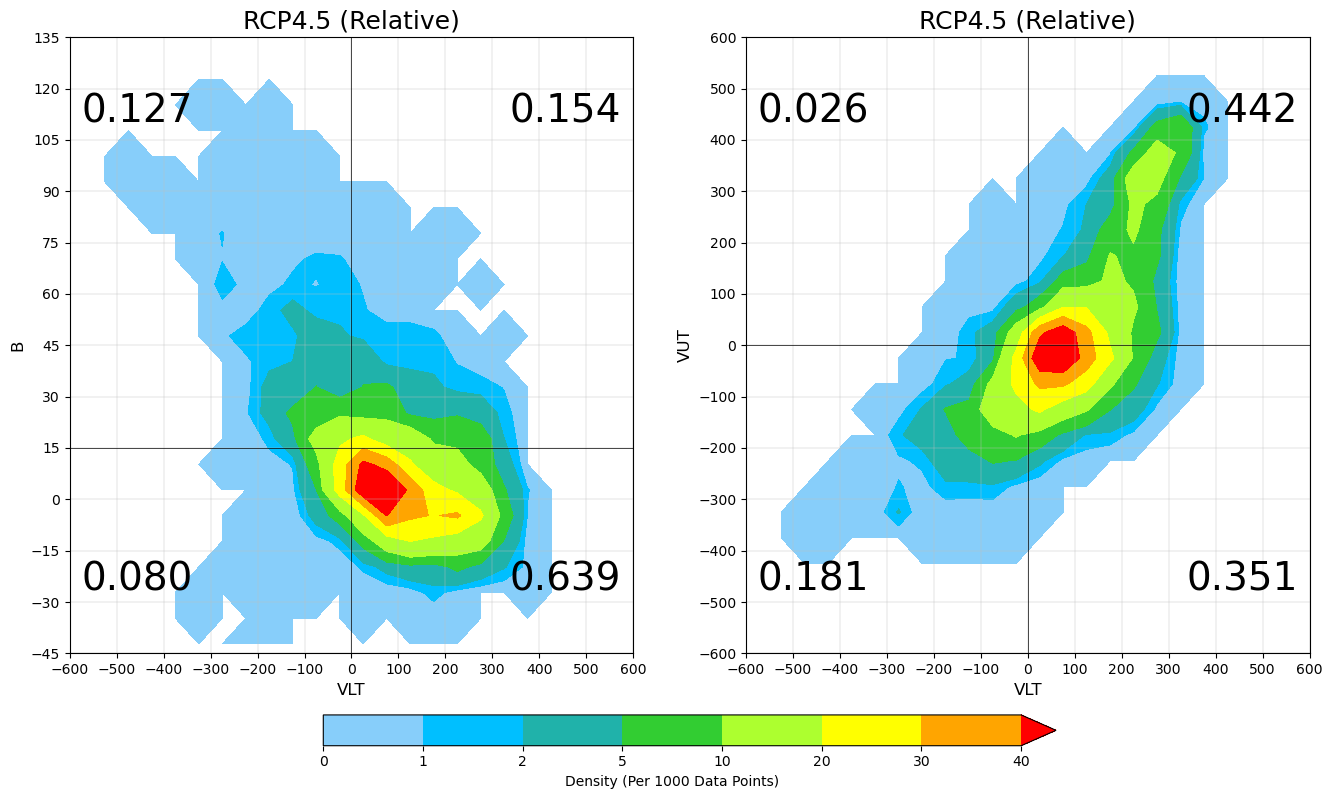

In [17]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_Data, "RCP4.5", True, False, True, "RCP45_Phase_Distr_Rela")

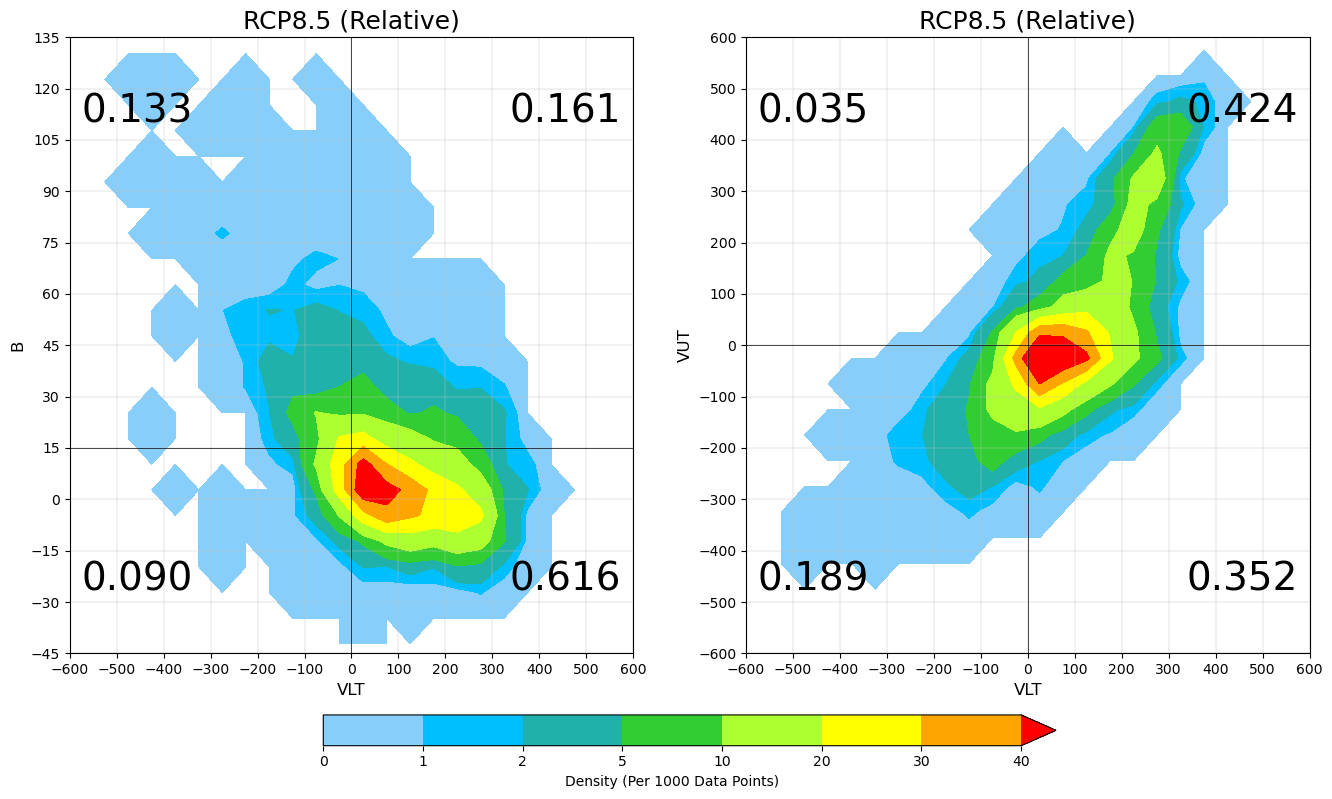

In [18]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_Data, "RCP8.5", True, False, True, "RCP85_Phase_Distr_Rela")

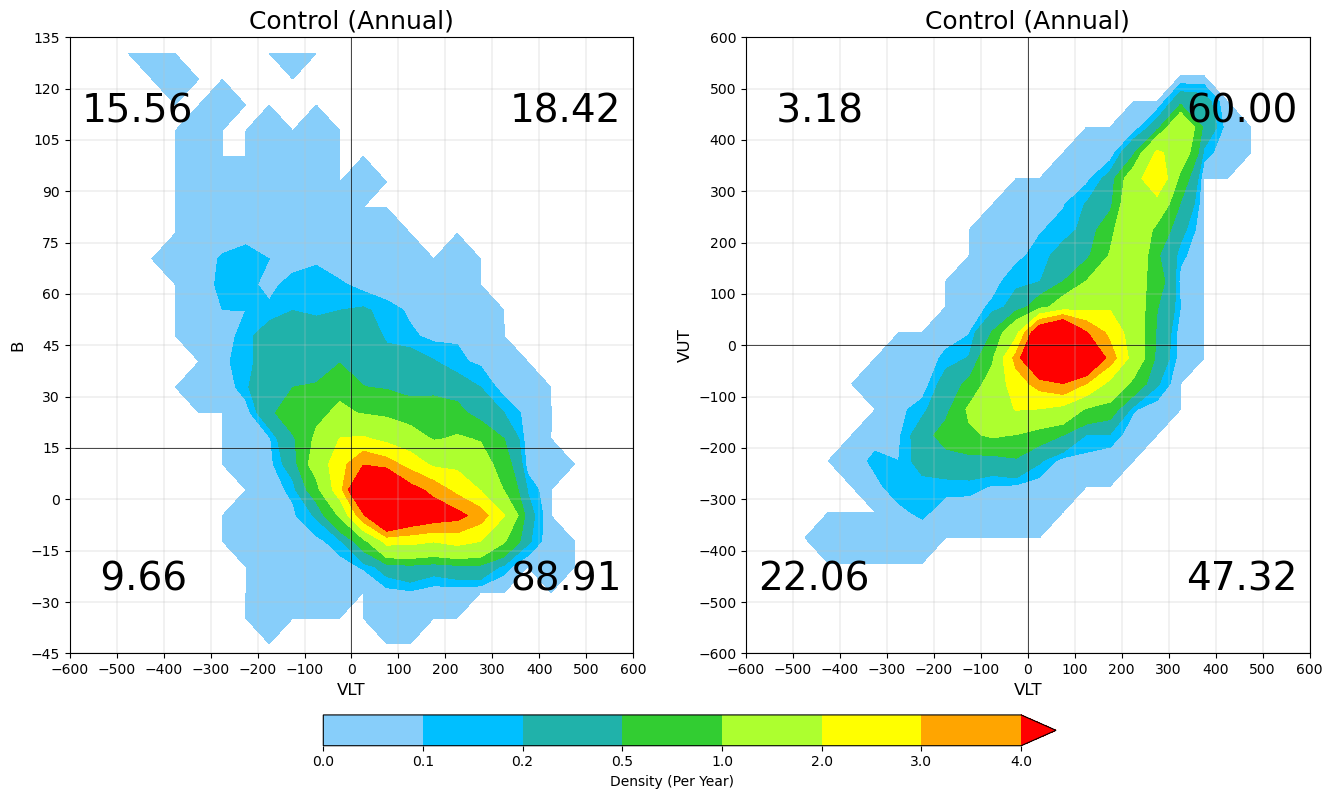

In [19]:
# Plot Annual Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_Data, "Control", False, False, True, "Control_Phase_Distr_Annual")

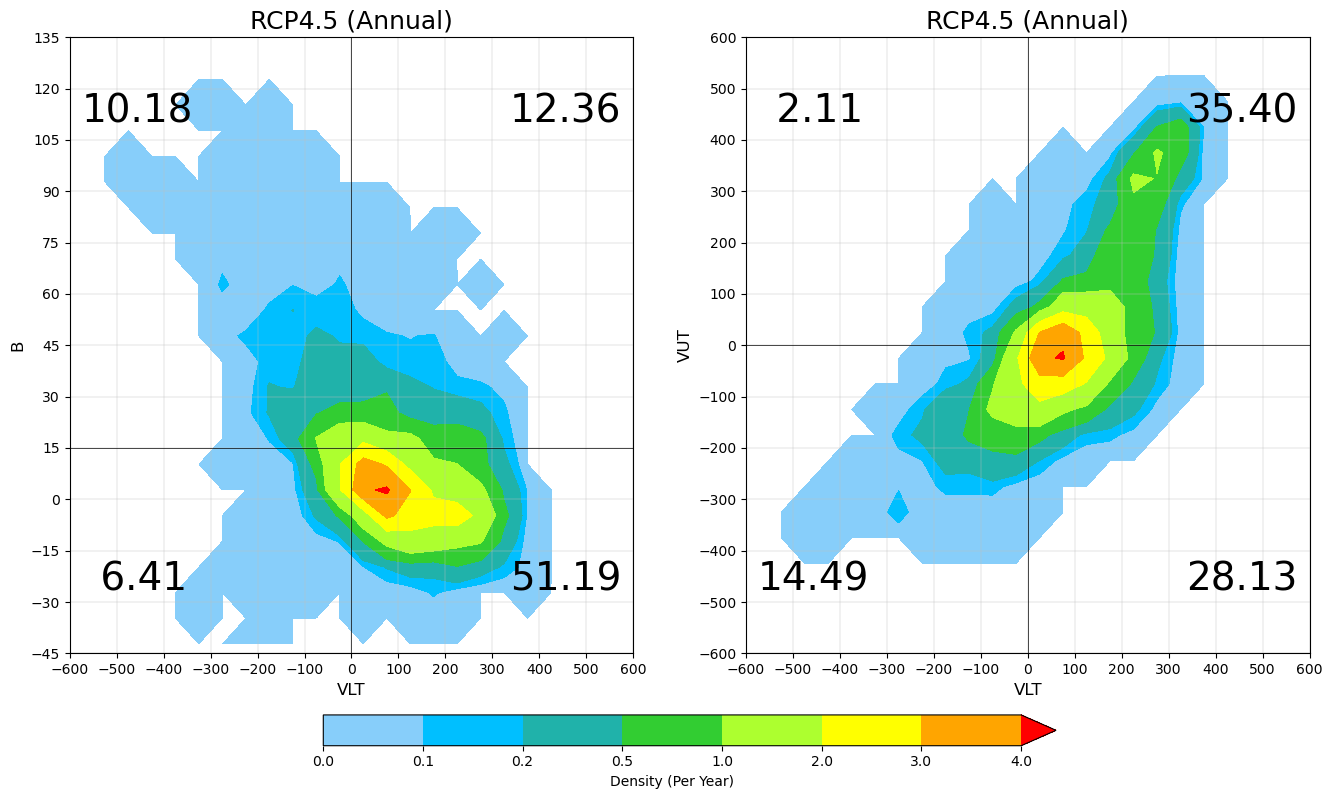

In [20]:
# Plot Annual Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_Data, "RCP4.5", False, False, True, "RCP45_Phase_Distr_Annual")

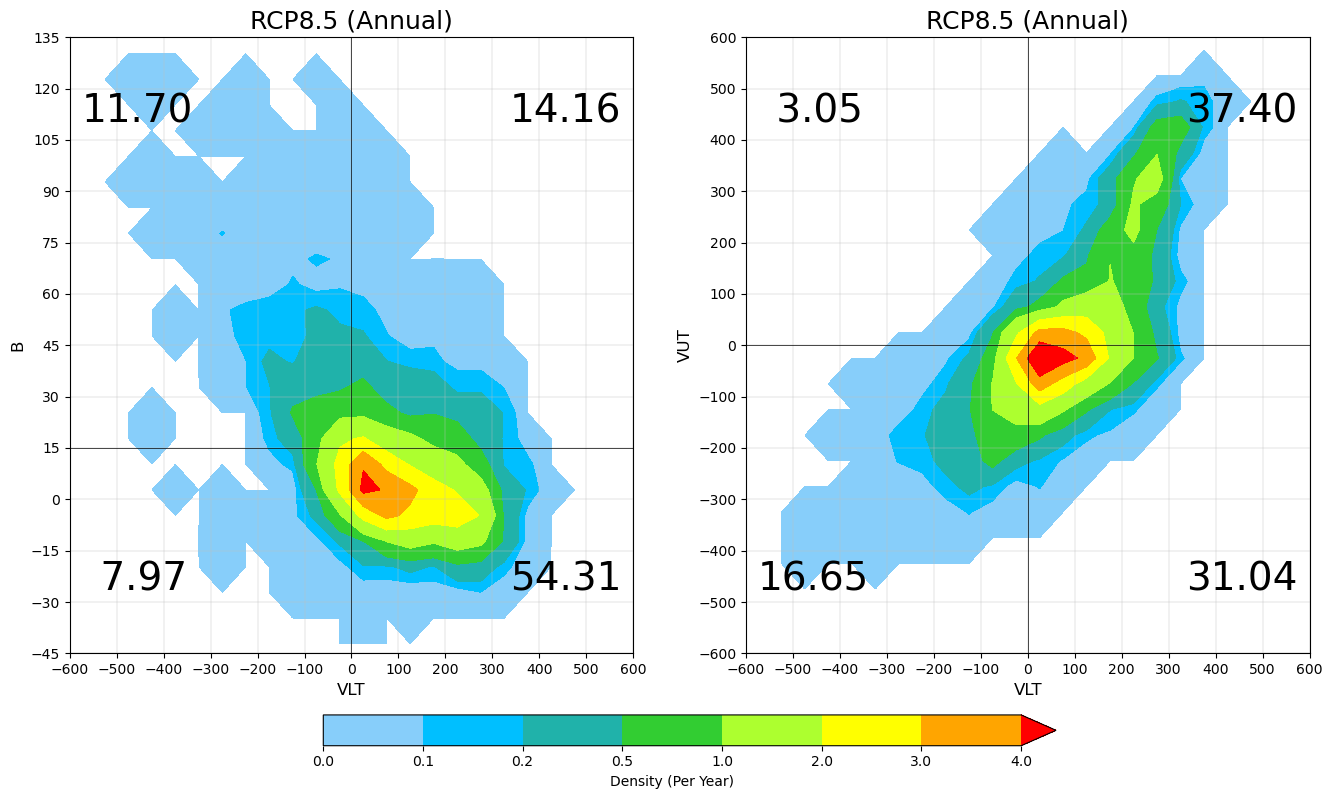

In [21]:
# Plot Annual Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_Data, "RCP8.5", False, False, True, "RCP85_Phase_Distr_Annual")

In [22]:
# Calculate Difference Between Models
def Phase_Space_Diff(DF_1, DF_2, Model_1, Model_2, Rela, Smooth):
    if Smooth == False:
        VLT_B_1, VLT_VUT_1 = Phase_Space_Distr(DF_1, VLT_Bins, B_Bins, Model_1, Rela)
        VLT_B_2, VLT_VUT_2 = Phase_Space_Distr(DF_2, VLT_Bins, B_Bins, Model_2, Rela)
    else:
        VLT_B_1, VLT_VUT_1 = Phase_Space_Distr_Smooth(DF_1, VLT_Bins, B_Bins, Model_1, Rela)
        VLT_B_2, VLT_VUT_2 = Phase_Space_Distr_Smooth(DF_2, VLT_Bins, B_Bins, Model_2, Rela)
    VLT_B_Diff = VLT_B_1 - VLT_B_2
    VLT_VUT_Diff = VLT_VUT_1 - VLT_VUT_2
    VLT_B_Quadrant_Percent = Phase_Space_Quadrant(VLT_B_1, "B", Rela) - Phase_Space_Quadrant(VLT_B_2, "B", Rela)
    VLT_VUT_Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT_1, "VUT", Rela) - Phase_Space_Quadrant(VLT_VUT_2, "VUT", Rela)
    return (VLT_B_Diff, VLT_VUT_Diff, VLT_B_Quadrant_Percent, VLT_VUT_Quadrant_Percent)

In [23]:
# Create Function of Colours of Cyclone Phase Difference Plots
Diff_Colours = ['mediumblue', 'deepskyblue', 'cyan', 'lawngreen', 'white', 'lawngreen', \
'gold', 'darkorange', 'red']
Rela_Diff_Bounds = numpy.array([-6,-4,-2,-0.0001,0.0001,2,4,6])
Annual_Diff_Bounds = numpy.array([-3,-2,-1,-0.0001,0.0001,1,2,3])

In [24]:
# Plot Cyclone Phase Distribution Difference Between ERA and REA
def Phase_Diff_Plot(Model_1, Model_2, DF_1, DF_2, Rela, Smooth, Savefig, Figname):
    VLT_B_Diff, VLT_VUT_Diff, VLT_B_Quadrant_Percent, VLT_VUT_Quadrant_Percent = \
    Phase_Space_Diff(DF_1, DF_2, Model_1, Model_2, Rela, Smooth)
#
# Define Colours and Bounds
    if Rela == True:
        Diff_Bounds = Rela_Diff_Bounds
    else:
        Diff_Bounds = Annual_Diff_Bounds
    Fig = pyplot.figure(figsize=(16,8))
#
# VLT B Distribution
    Axis = Fig.add_subplot(1,2,1)
    VLT_Vals = VLT_Bins[1:] - 25
    B_Vals = B_Bins[1:] - 4.75
    pyplot.contourf(VLT_Vals, B_Vals, VLT_B_Diff, levels=Diff_Bounds, colors=Diff_Colours, extend='both')
    Phase_Diff_Formatting("B", Model_1, Model_2, Rela, Axis)
# Add Quadrant Percent
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(VLT_B_Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % VLT_B_Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % VLT_B_Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(1,2,2)
    VLT_Vals = VLT_Bins[1:] - 25
    VUT_Vals = VLT_Bins[1:] - 25
    pyplot.contourf(VLT_Vals, VUT_Vals, VLT_VUT_Diff, levels=Diff_Bounds, colors=Diff_Colours, extend='both')
    Phase_Diff_Formatting("VUT", Model_1, Model_2, Rela, Axis)
# Add Quadrant Percent
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(VLT_VUT_Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % VLT_VUT_Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % VLT_VUT_Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    if Rela == True:
        Cbar_Label = 'Density Difference (Per 1000 Data Points)'
    else:
        Cbar_Label = 'Density Difference (Per Year)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Diff_Colours, N=len(Diff_Colours))
    Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, spacing='proportional', \
    label=Cbar_Label, ticks=Diff_Bounds, shrink=0.7)
#
# Save Fig
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname+'.png', bbox_inches='tight')

In [25]:
# Formatting For Cyclone Phase Difference Plot
def Phase_Diff_Formatting(y_Var, Model_1, Model_2, Rela, Axis):
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    if y_Var == "B":
        y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
        pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
        pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    else:
        y_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
        pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
        pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel(y_Var, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Rela == True:
        pyplot.title(str(Model_1 + ' - ' + Model_2 + ' (Relative)'), fontsize=18)
    else:
        pyplot.title(str(Model_1 + ' - ' + Model_2 + ' (Annual)'), fontsize=18)

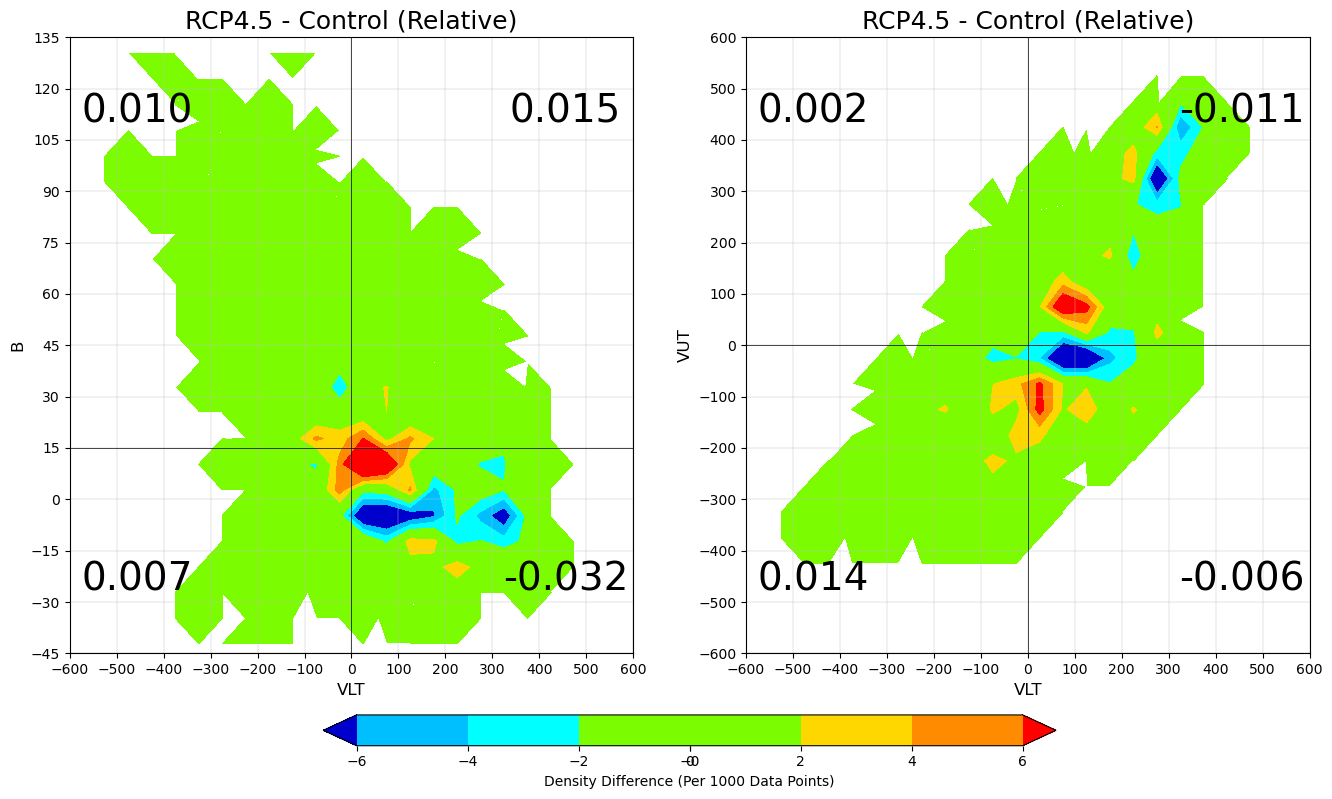

In [26]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_Data, Control_Data, \
True, False, True, "RCP45-Control_Phase_Diff_Rela")

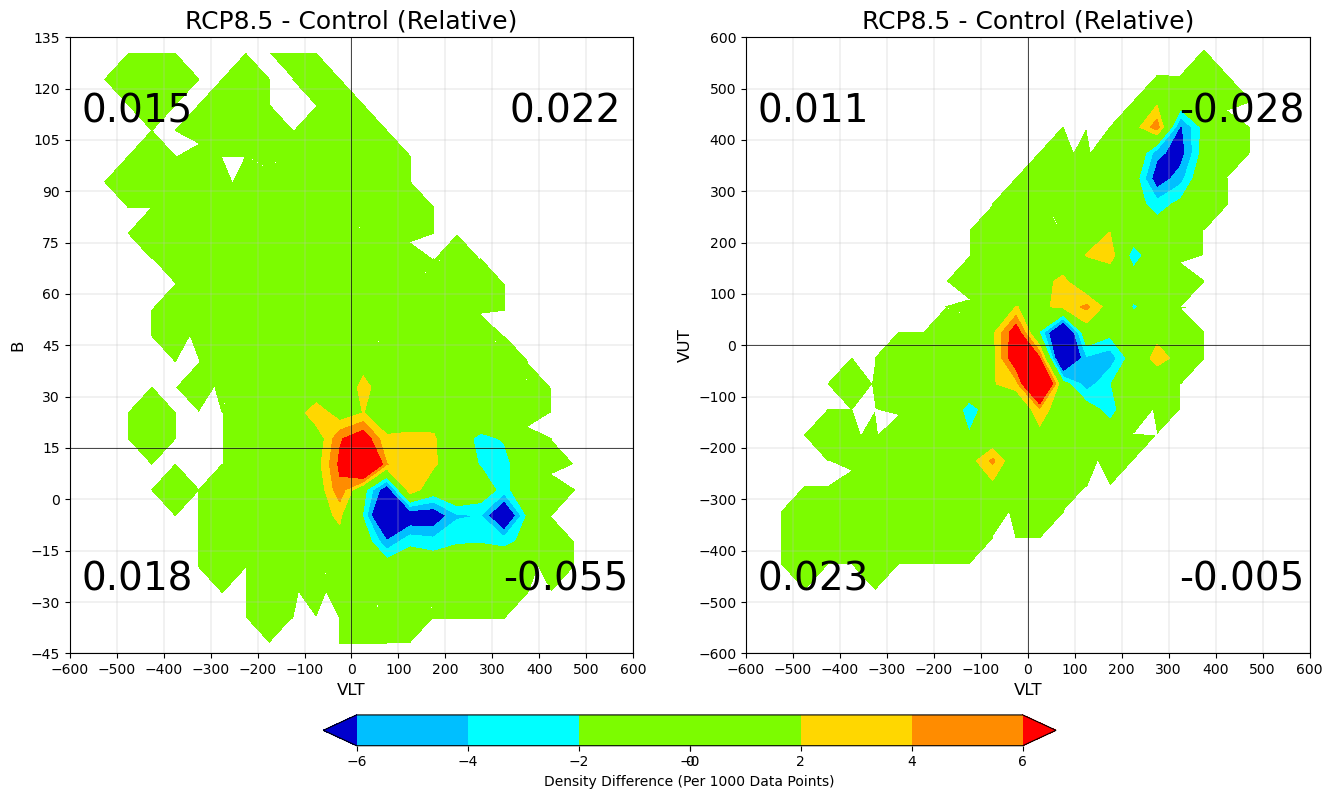

In [27]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_Data, Control_Data, \
True, False, True, "RCP85-Control_Phase_Diff_Rela")

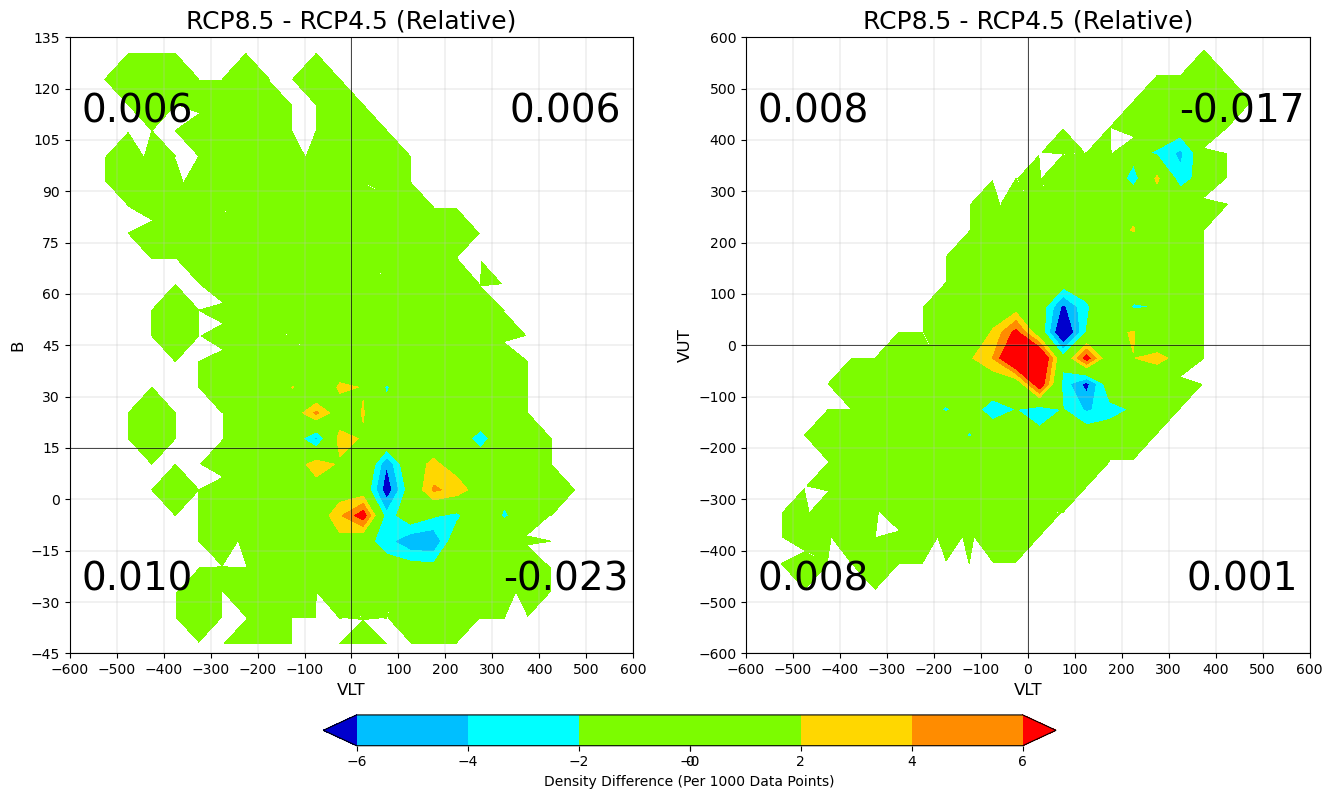

In [28]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - RCP4.5
Phase_Diff_Plot("RCP8.5", "RCP4.5", RCP85_Data, RCP45_Data, \
True, False, True, "RCP85-RCP45_Phase_Diff_Rela")

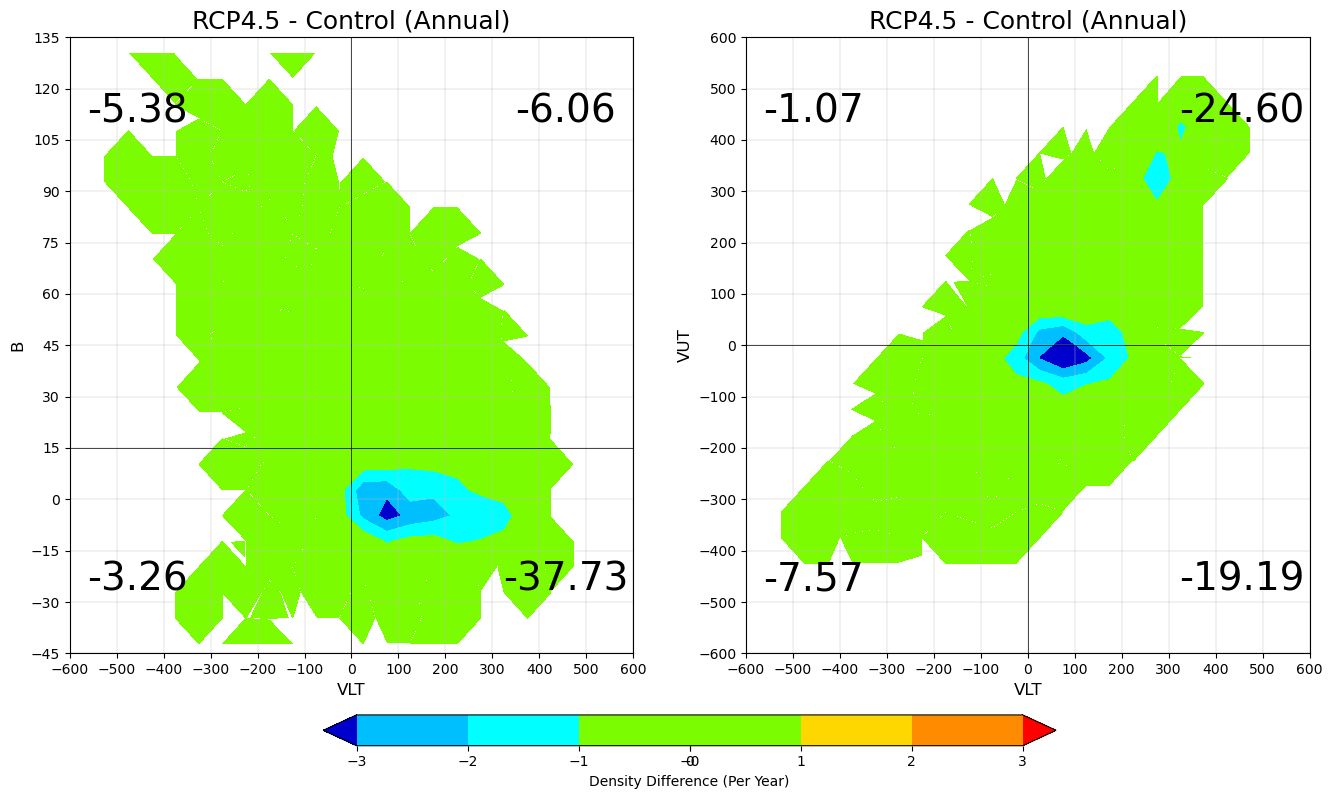

In [29]:
# Plot Annual Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_Data, Control_Data, \
False, False, True, "RCP45-Control_Phase_Diff_Annual")

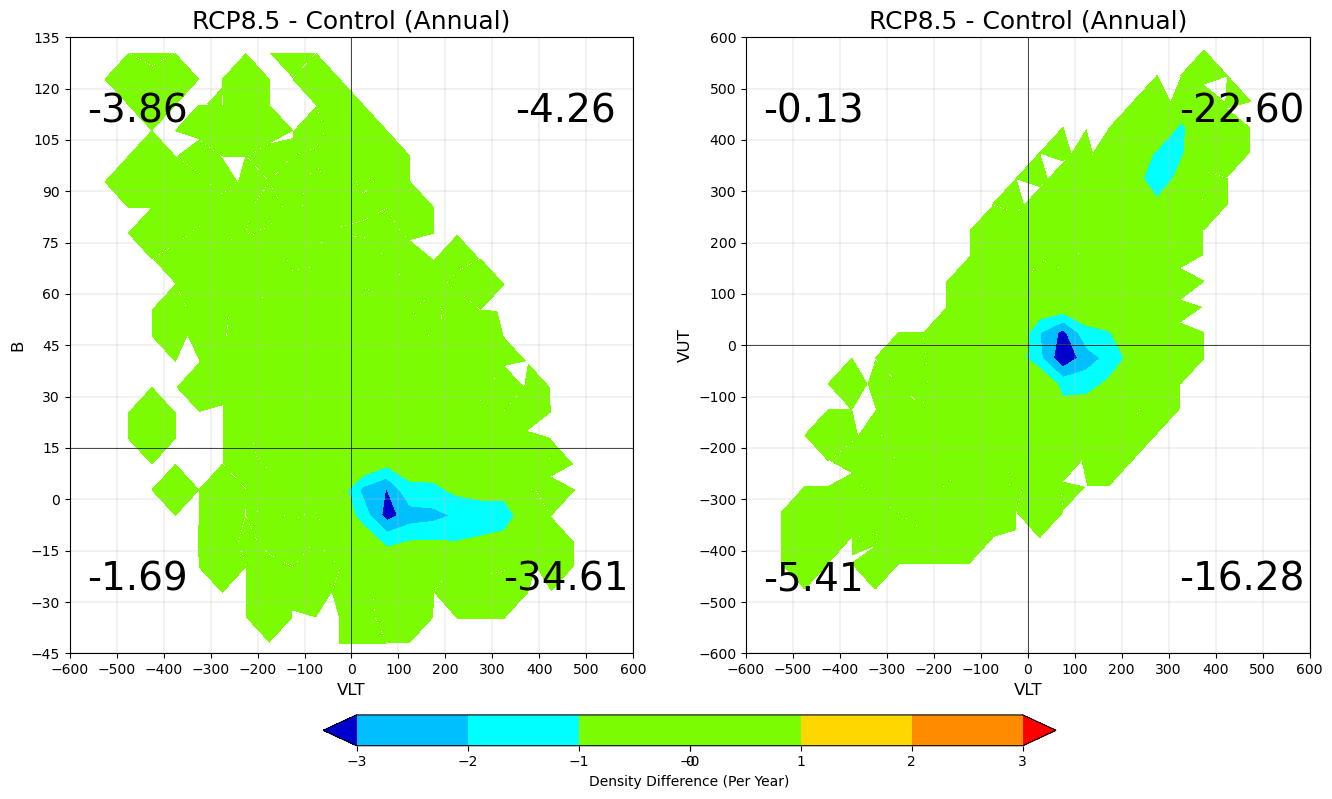

In [30]:
# Plot Annual Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_Data, Control_Data, \
False, False, True, "RCP85-Control_Phase_Diff_Annual")

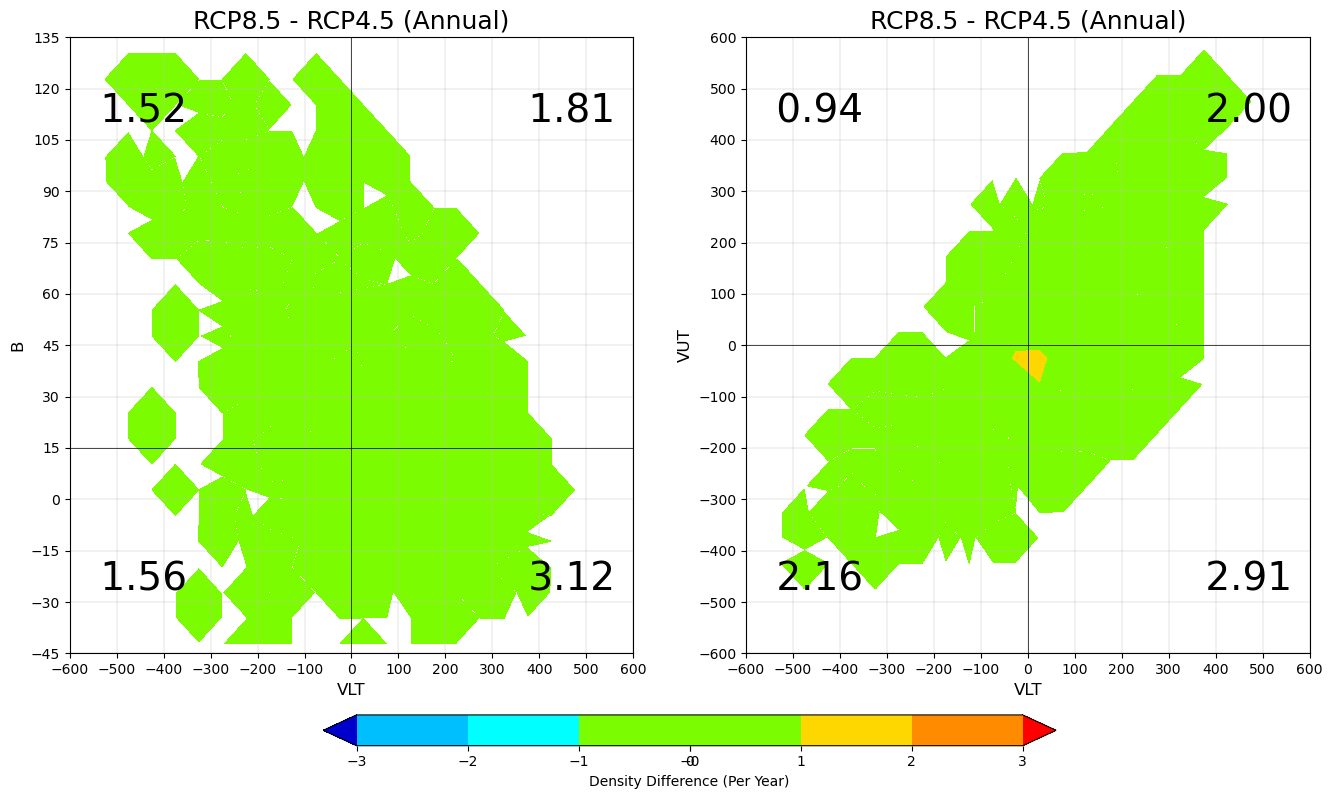

In [31]:
# Plot Annual Difference Between Phase Space Distributions of RCP8.5 - RCP4.5
Phase_Diff_Plot("RCP8.5", "RCP4.5", RCP85_Data, RCP45_Data, \
False, False, True, "RCP85-RCP45_Phase_Diff_Annual")

In [32]:
# Create Subset of Data: Below 980hPa
Control_980hPa = Control_Data[Control_Data["SLP(hPa)"] <= 980].reset_index()
RCP45_980hPa = RCP45_Data[RCP45_Data["SLP(hPa)"] <= 980].reset_index()
RCP85_980hPa = RCP85_Data[RCP85_Data["SLP(hPa)"] <= 980].reset_index()

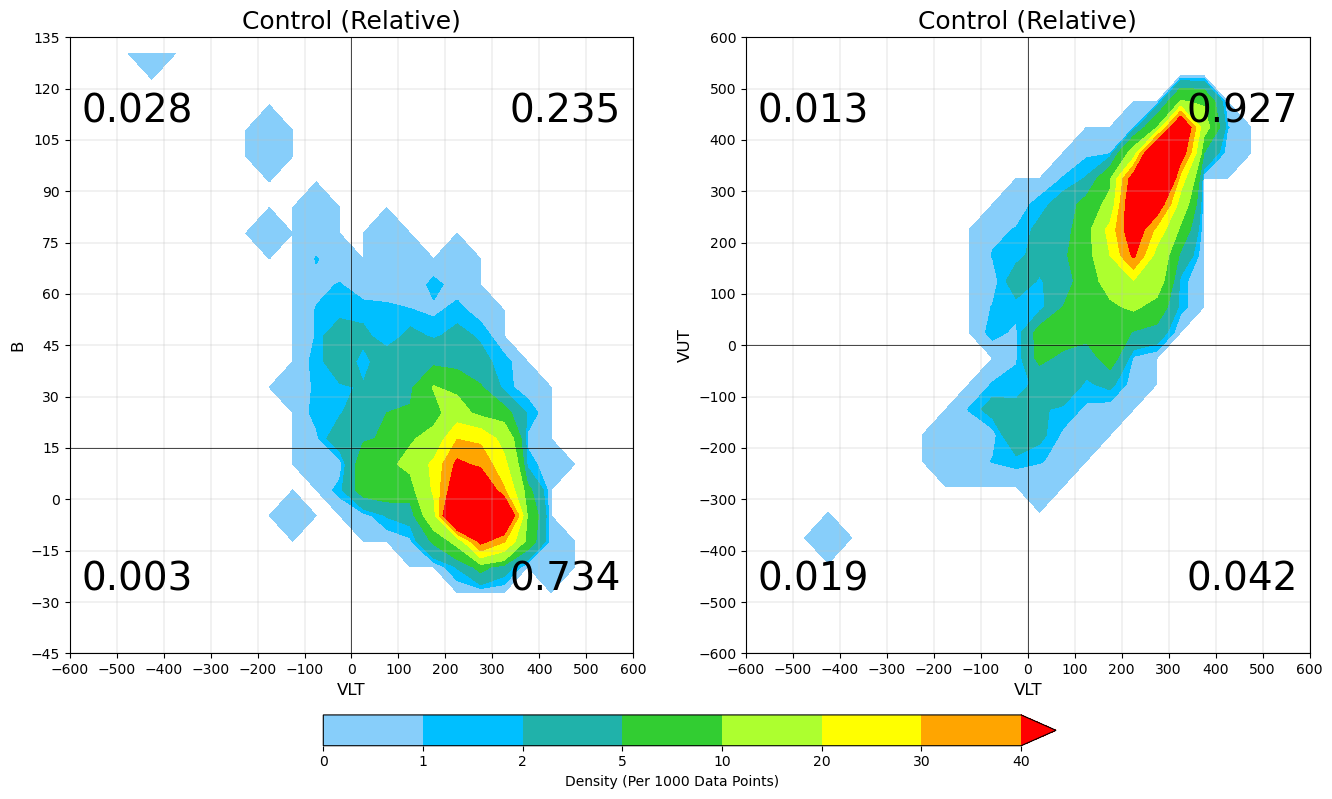

In [33]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_980hPa, "Control", True, False, True, \
"Control_Phase_Distr_980hPa")

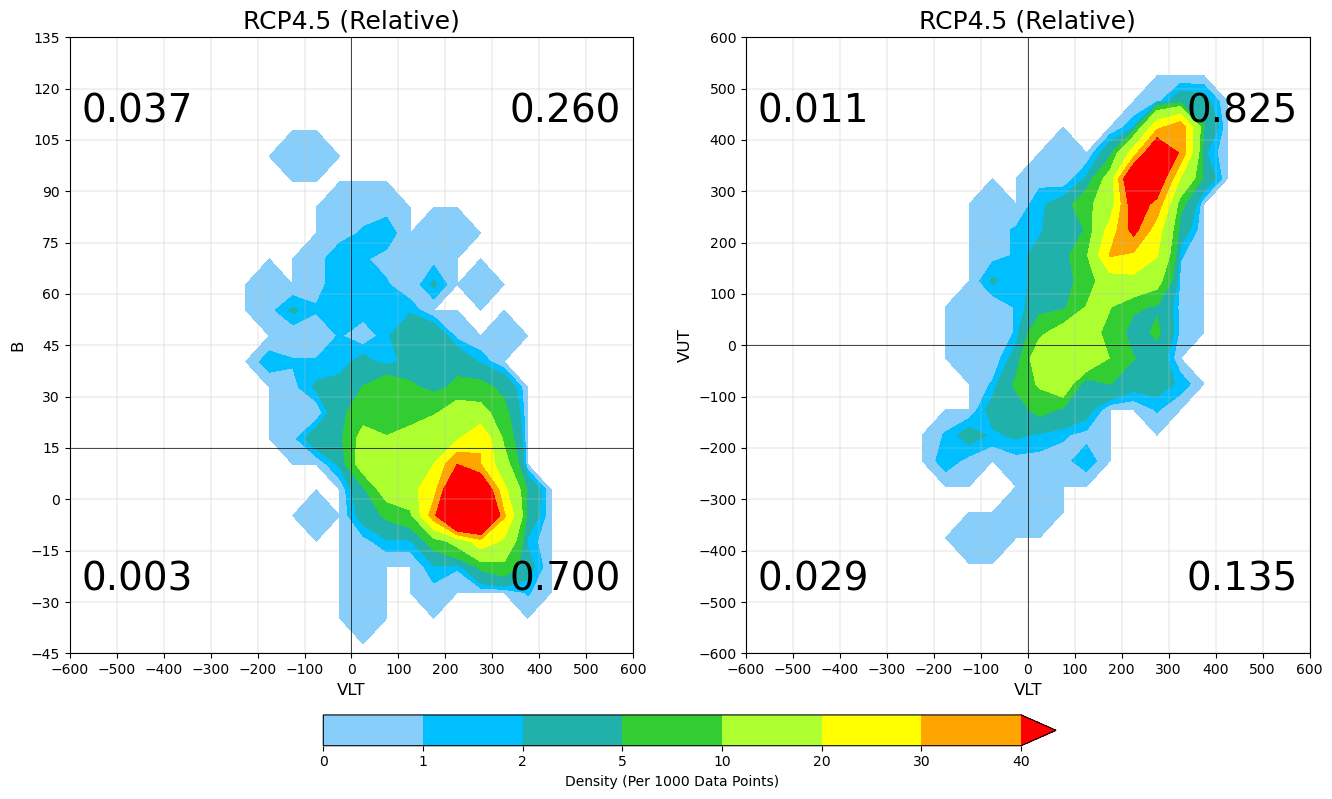

In [34]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_980hPa, "RCP4.5", True, False, True, \
"RCP45_Phase_Distr_980hPa")

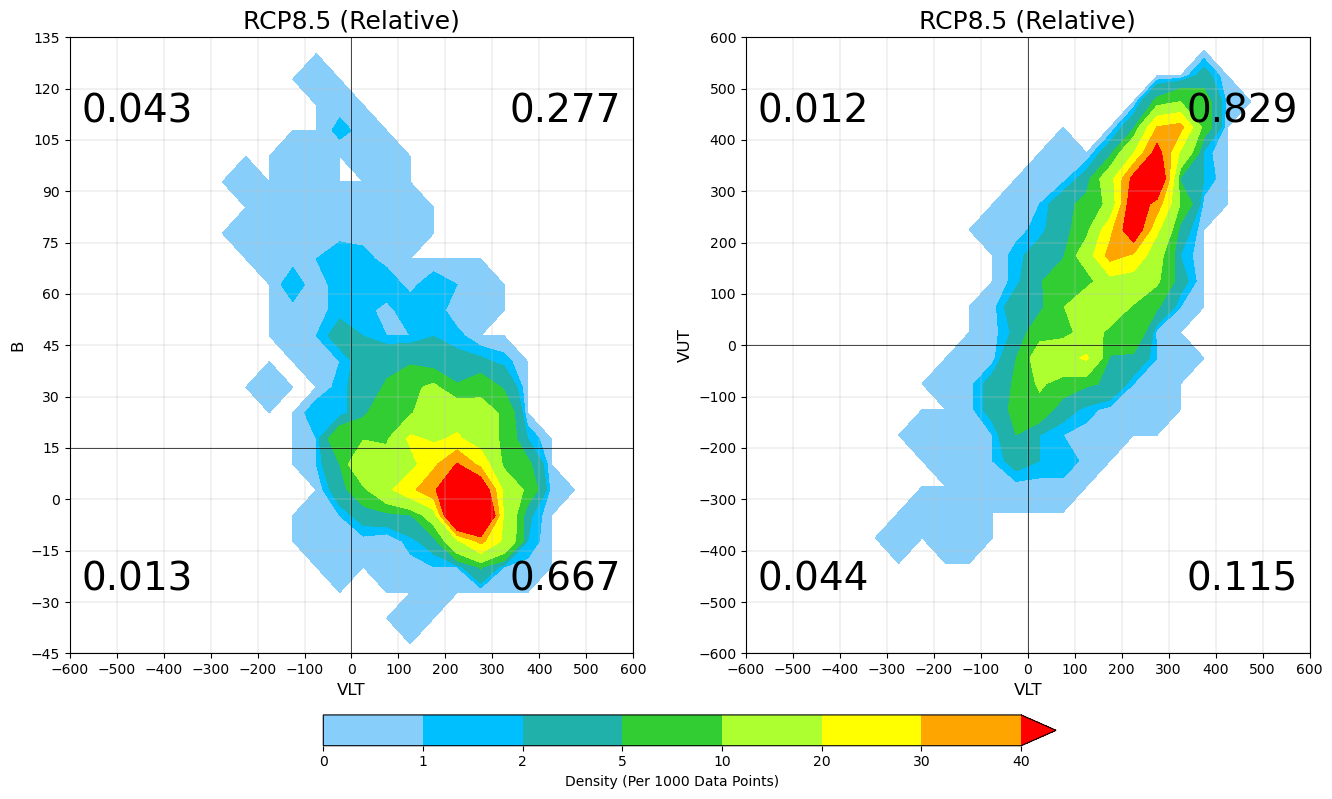

In [35]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_980hPa, "RCP8.5", True, False, True, \
"RCP85_Phase_Distr_980hPa")

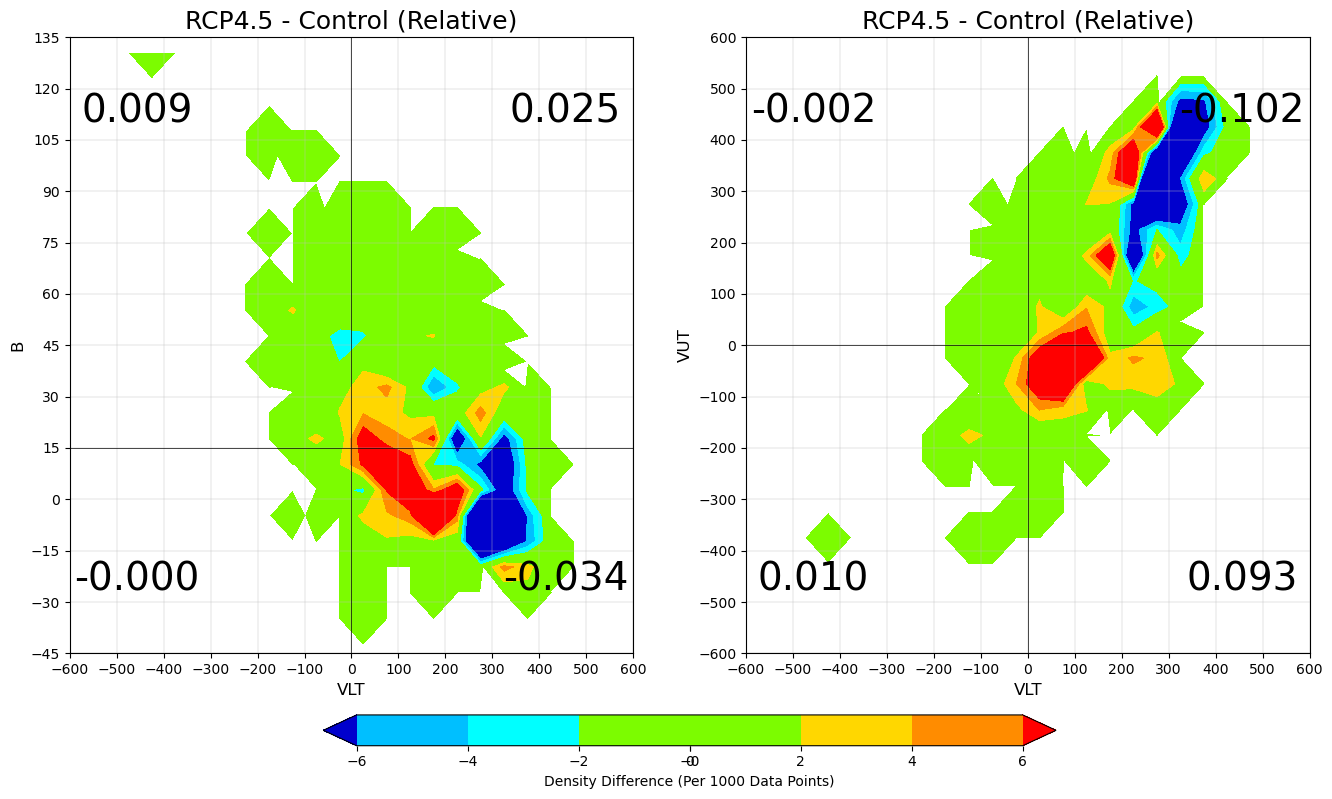

In [36]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_980hPa, Control_980hPa, \
True, False, True, "RCP45-Control_Phase_Diff_980hPa")

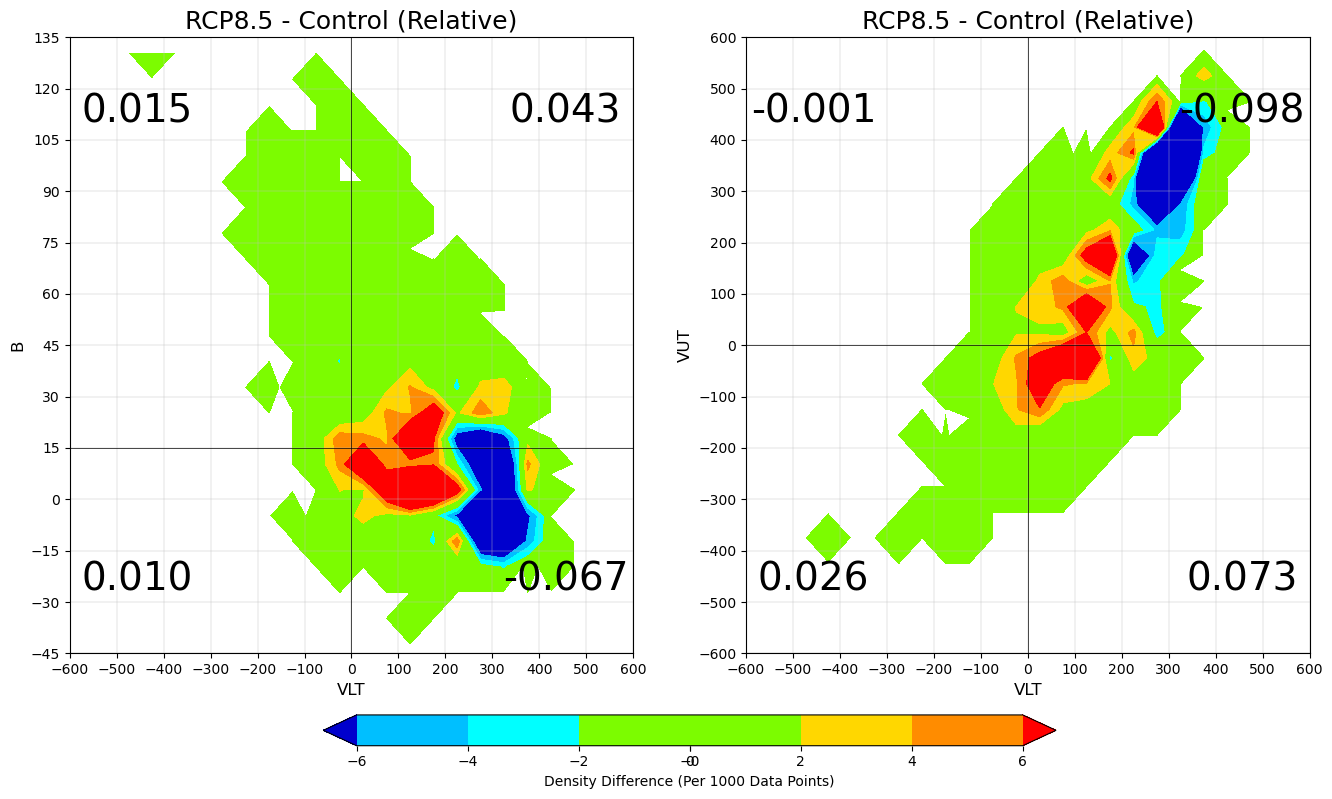

In [37]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_980hPa, Control_980hPa, \
True, False, True, "RCP85-Control_Phase_Diff_980hPa")